# What is the best mix of genre types to maximize viewership?
## Assuming that having more ratings means a higher viewership of the movie.
## Secondary goal is a movie that is well liked, with an average rating greater than 4.0

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#get required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import sklearn
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

from numpy import arange
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso

pd.set_option('display.max_columns',200) #allows for up to 500 columns to be displayed when viewing a dataframe
pd.set_option('display.max_rows',100)
plt.style.use('seaborn') # a style that can be used for plots - see style reference above

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
users = pd.read_csv('users.dat', sep='::', names=['gender', 'age', 'user_id', 'twitter_id'], engine = 'python')

ratings = pd.read_csv('ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'rating_timestamp'], engine = 'python')
ratings["rating_timestamp"] = pd.to_datetime(ratings["rating_timestamp"], unit='s')

movies = pd.read_csv('movies.dat', sep='::', header=None, names=['movie_id', 'movie_title', 'genres'], index_col = 'movie_id', engine = 'python')

In [4]:
#users.head()

In [5]:
#users.info()

In [6]:
#ratings.head()

In [7]:
#ratings.info()

In [8]:
#movies.head()

In [9]:
#movies.info()

In [10]:
#movies.describe()

In [11]:
ratings = ratings.merge(movies, left_on='movie_id', right_on='movie_id')
#ratings

In [12]:
user_ratings = ratings.merge(users, left_on = 'user_id', right_on = 'user_id')
#ratings

In [13]:
movies['genres'].value_counts()

Drama                              843
Comedy                             521
Horror                             178
Comedy|Drama                       162
Comedy|Romance                     142
                                  ... 
Adventure|Fantasy                    1
Adventure|Drama|Western              1
Action|Adventure|Drama|Thriller      1
Musical|Romance|War                  1
Film-Noir|Sci-Fi|Thriller            1
Name: genres, Length: 301, dtype: int64

In [14]:
ratings['genres'].value_counts()

Comedy                       116883
Drama                        111423
Comedy|Romance                42712
Comedy|Drama                  42245
Drama|Romance                 29170
                              ...  
Drama|Romance|Western            29
Children's|Fantasy               27
Comedy|Film-Noir|Thriller         5
Film-Noir|Horror                  2
Fantasy                           1
Name: genres, Length: 301, dtype: int64

Comedy appears the most looking surface level data. <br>
Comedy also has less movies in the category than Drama.

In [15]:
#Finds the ratings per movie in the comedy genre by searching through all genres with the word "comedy"
comedy_ratings = ratings[ratings['genres'].str.contains('Comedy')]
countmovies = comedy_ratings['movie_title'].nunique()
ratingspmovie = comedy_ratings.shape[0] / countmovies
print('Ratings per comedy movie, including all sub-genres:', ratingspmovie)

Ratings per comedy movie, including all sub-genres: 306.603611349957


Method is next expanded to all categories.

In [17]:
#loop through genres and find highest ratings per movie
genresarray = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
#create ratings per movie array for the purpose of building a plot
ratingspmoviearray = []
maxgenre = ''
smaxgenre = ''
tmaxgenre = ''
maxratings = 0
smaxratings = 0
tmaxratings = 0
for genre in genresarray:
    target_ratings = ratings[ratings['genres'].str.contains(genre)]
    countmovies = target_ratings['movie_title'].nunique()
    ratingspmovie = target_ratings.shape[0] / countmovies
    if ratingspmovie > maxratings:
        tmaxratings = smaxratings
        smaxratings = maxratings
        maxratings = ratingspmovie
        tmaxgenre = smaxgenre
        smaxgenre = maxgenre
        maxgenre = genre
    ratingspmoviearray.append(ratingspmovie)


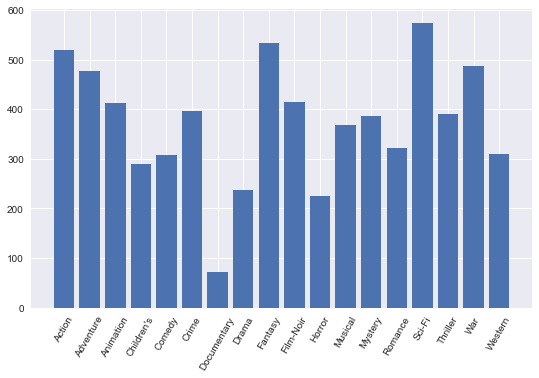

In [18]:
plt.bar(genresarray, height = ratingspmoviearray)
plt.xticks(rotation=60)
plt.show()

Visualizing total ratings by genre including all sub genres shows that comedy is not the highest.

In [19]:
print('Genre with highest ratings per movie:')
print(maxgenre)
print('Ratings per movie:')
print(maxratings)

print()

print('Genre with the second highest ratings per movie:')
print(smaxgenre)
print('Ratings per movie:')
print(smaxratings)

print()

print('Genre with the third highest ratings per movie:')
print(tmaxgenre)
print('Ratings per movie:')
print(tmaxratings)

Genre with highest ratings per movie:
Sci-Fi
Ratings per movie:
574.0656934306569

Genre with the second highest ratings per movie:
Fantasy
Ratings per movie:
533.8382352941177

Genre with the third highest ratings per movie:
Action
Ratings per movie:
520.1151515151515


In [20]:
#Show movie genre mixes with the highest average ratings for all movies with that genre mix for the second highest ratingspmovie genre
target_ratings = ratings[ratings['genres'].str.contains(tmaxgenre)]
target_ratings = target_ratings.groupby('genres', as_index=False)['rating'].mean()
target_ratings = target_ratings.sort_values(by = 'rating', ascending=False)
print('average ratings for genre', tmaxgenre)
target_ratings.head(10)

average ratings for genre Action


,genres,rating
21,Action|Adventure|Drama|Sci-Fi|War,4.292977
32,Action|Adventure|Romance|War,4.251656
2,Action|Adventure|Animation,4.147826
88,Action|Sci-Fi|Thriller|War,4.125824
57,Action|Crime|Drama,4.110883
95,Action|Western,4.079613
67,Action|Drama|Mystery|Romance|Thriller,4.054475
73,Action|Drama|War,4.047693
30,Action|Adventure|Romance|Sci-Fi|War,4.022893
61,Action|Crime|Romance,3.974768


In [21]:
#Show movie genre mixes with the highest average ratings for all movies with that genre mix for the second highest ratingspmovie genre
target_ratings = ratings[ratings['genres'].str.contains(smaxgenre)]
target_ratings = target_ratings.groupby('genres', as_index=False)['rating'].mean()
target_ratings = target_ratings.sort_values(by = 'rating', ascending=False)
print('average ratings for genre', smaxgenre)
target_ratings.head(10)

average ratings for genre Fantasy


,genres,rating
32,Fantasy,4.000000
22,Children's|Drama|Fantasy|Sci-Fi,3.965183
3,Action|Adventure|Fantasy|Sci-Fi,3.904041
31,Drama|Fantasy|Romance|Thriller,3.865828
17,Animation|Children's|Drama|Fantasy,3.842623
6,Action|Drama|Fantasy|Romance,3.812668
9,Adventure|Children's|Comedy|Fantasy,3.764430
16,Adventure|Fantasy|Sci-Fi,3.681250
18,Animation|Children's|Fantasy|Musical,3.659933
25,Children's|Fantasy|Sci-Fi,3.652113


Fantasy does not meet ratings requirements despite viewership.

In [22]:
#Show movie genre mixes with the highest average ratings for all movies with that genre mix for the highest ratingspmovie genre
target_ratings = ratings[ratings['genres'].str.contains(maxgenre)]
target_ratings = target_ratings.groupby('genres', as_index=False)['rating'].mean()
target_ratings = target_ratings.sort_values(by = 'rating', ascending=False)
print('average ratings for genre', maxgenre)
target_ratings.head(10)

average ratings for genre Sci-Fi


,genres,rating
68,Sci-Fi|War,4.449890
4,Action|Adventure|Drama|Sci-Fi|War,4.292977
59,Film-Noir|Sci-Fi,4.273333
24,Action|Sci-Fi|Thriller|War,4.125824
54,Drama|Mystery|Sci-Fi|Thriller,4.068765
7,Action|Adventure|Romance|Sci-Fi|War,4.022893
43,Children's|Drama|Fantasy|Sci-Fi,3.965183
55,Drama|Romance|Sci-Fi,3.951613
41,Animation|Sci-Fi,3.945238
30,Adventure|Animation|Sci-Fi|Thriller,3.933628


## The best movie to make to maximize viewership while also ensuring ratings over 4.0 would be a science fiction war movie with action, adventure, and drama elements.